# Project Instructions

The insurance company Sure Tomorrow wants to solve several tasks with the help of machine learning and asks you to evaluate this possibility.
- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict the probability of a new customer receiving an insurance benefit. Can a predictive model perform better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect customer personal data without affecting the model from the previous exercise. It is necessary to develop a data transformation algorithm that makes it difficult to recover personal information if the data falls into the wrong hands. This is called data masking or obfuscation. However, the data must be protected in such a way that the quality of the machine learning models is not affected. It is not necessary to choose the best model; it is enough to demonstrate that the algorithm works correctly.


# Data preprocessing and exploration

In [4]:
pip install scikit-learn --upgrade


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [59]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import root_mean_squared_error, r2_score

import math
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from IPython.display import display

## Load data

In [10]:
df = pd.read_csv('/Users/pauli/Documents/Data/sure_tomorrow/insurance_us.csv')

Renamed the columns so that the code looks more consistent with its style.

In [11]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [12]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
788,1,30.0,63200.0,1,0
3717,0,34.0,32700.0,0,0
2527,1,20.0,37600.0,1,0
567,1,33.0,58000.0,2,0
3612,1,39.0,32800.0,5,0
848,1,32.0,42800.0,2,0
2812,1,44.0,32600.0,1,1
3559,0,30.0,46500.0,2,0
2680,1,41.0,31200.0,1,0
684,1,52.0,55800.0,1,2


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [14]:
# Change the age type (from float to int):

df['age']= df['age'].astype(int)

In [15]:
#Check that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [16]:
# Take a look at the descriptive statistics of the data.

In [17]:
df.describe(percentiles = np.linspace(0,1,11))

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
0%,0.000000,18.000000,5300.000000,0.000000,0.000000
10%,0.000000,20.000000,27200.000000,0.000000,0.000000
20%,0.000000,23.000000,31700.000000,0.000000,0.000000
30%,0.000000,25.000000,34700.000000,0.000000,0.000000
40%,0.000000,28.000000,37400.000000,1.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000


There are no missing data, and it can be observed that very few clients have received insurance benefits, since up to the 80th percentile the value is 0. On the other hand, 50% of clients have at least one family member, and only 10% have three or more. Regarding income, 50% of clients earn up to 40,200, and 90% up to 52,500. The difference between the 10th percentile (27,200) and the 90th percentile (52,500) suggests moderate dispersion.

## EDA.

Let's quickly check if there are certain customer groups by looking at the pairs chart.

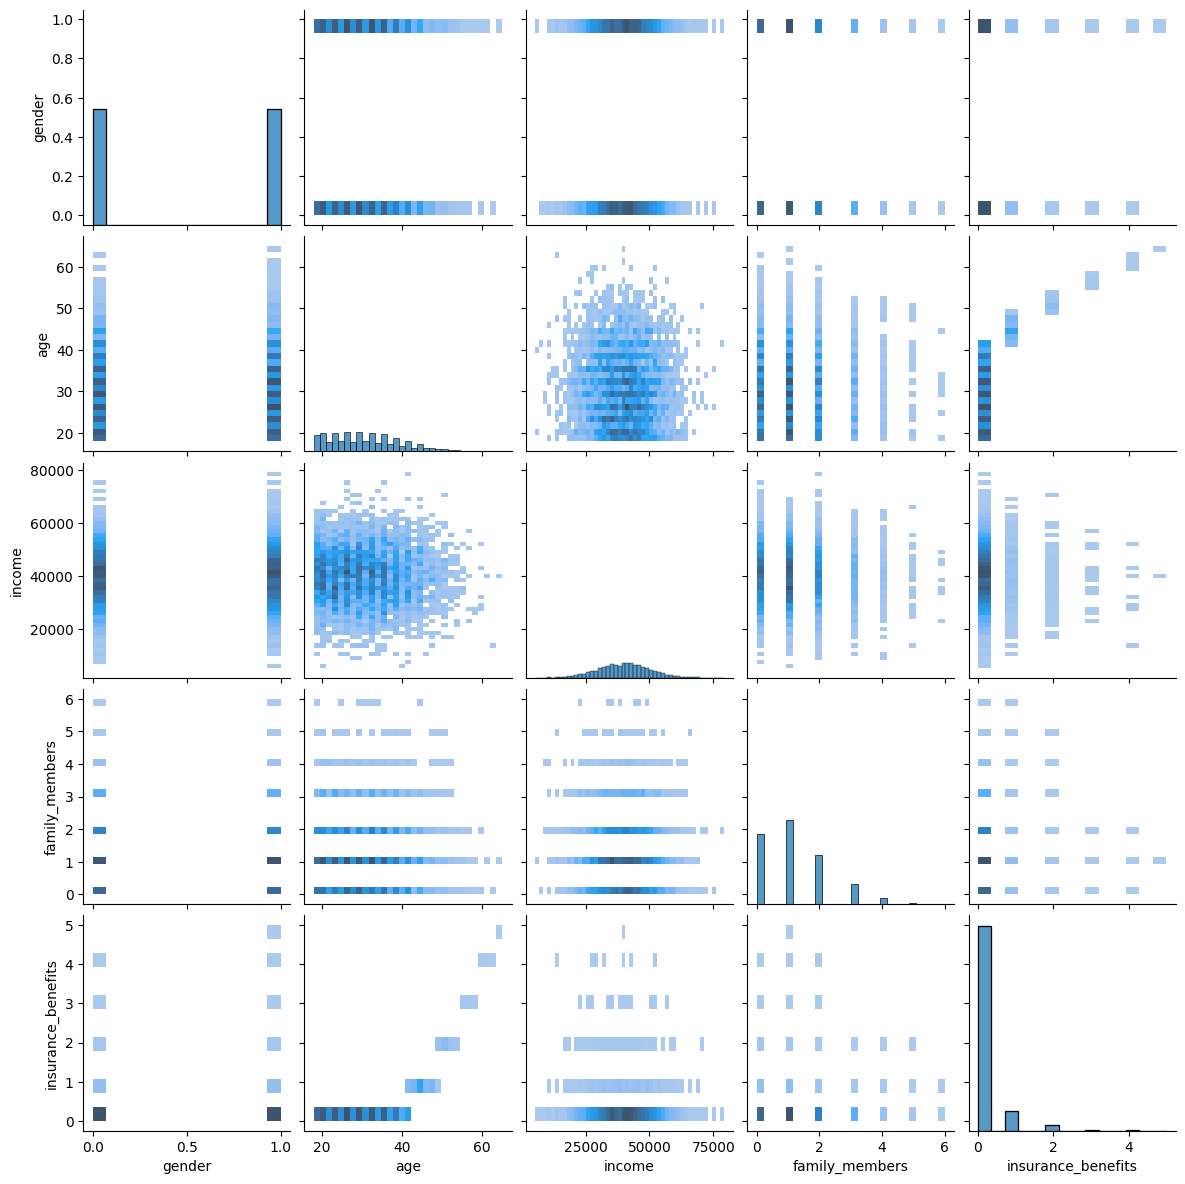

In [18]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

It's a bit tricky to spot obvious groups (clusters) because it's difficult to combine multiple variables simultaneously (to analyze multivariate distributions). This is where LA and ML can be quite useful.

# Task 1. Similar Clients

In the ML language, it is necessary to develop a procedure that returns the k nearest neighbors (objects) for a given object based on the distance between the objects.
We may want to review the following lessons (chapter -> lesson): Distance between vectors -> Euclidean distance
- Distance between vectors -> Manhattan distance

To solve the task, we can try different distance metrics.

Write a function that returns the k nearest neighbors for an $n^{th}$ object based on a specified distance metric. This task should not take into account the number of insurance claims received.
You can use an existing implementation of scikit-learn's kNN algorithm (see [link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or your own implementation.
Test it for four combinations of two cases: Scaling
- the data is unscaled
- the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Distance Metrics
- Euclidean
- Manhattan

Answer these questions: - Does the fact that the data is unscaled affect the kNN algorithm? If so, how does this manifest itself? - How similar are the results when using the Manhattan distance metric (regardless of scaling)?

In [19]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [20]:
def get_knn(df, n, k, metric):
    
    """
    Returns the k nearest neighbors

    :param df: Pandas DataFrame used to find similar objects within the same location
    :param n: Number of objects for which nearest neighbors are found
    :param k: Number of nearest neighbors to return
    :param metric: Name of the distance metric """

    nbrs = NearestNeighbors(n_neighbors= n, metric= metric)
    nbrs.fit(df)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scale data.

In [21]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

/var/folders/cq/bs731p7n52x64481gqr1xjvm0000gn/T/ipykernel_29321/760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.63076923 0.70769231 0.44615385 ... 0.30769231 0.33846154 0.43076923]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())
/var/folders/cq/bs731p7n52x64481gqr1xjvm0000gn/T/ipykernel_29321/760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.16666667 0.16666667 0.         ... 0.33333333 0.5        0.16666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())


In [22]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
4358,0,0.292308,0.544304,0.000000,0
3805,1,0.292308,0.530380,0.000000,0
1805,1,0.692308,0.451899,0.166667,1
3574,1,0.553846,0.513924,0.500000,0
1903,1,0.338462,0.465823,0.000000,0


Now, let's get similar records for a given customer, for each combination

In [23]:
# Client 5 is chosen for testing.

client_5 = df.iloc[4][feature_names]
print('Cliente de prueba: \n', client_5)

Cliente de prueba: 
 gender                1.0
age                  28.0
income            26100.0
family_members        0.0
Name: 4, dtype: float64


In [24]:
#Test on unscaled data using Euclidean distance

get_knn(df[feature_names], n=4, k=5, metric='euclidean')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,distance
4,1,28,26100.0,0,0.000000
2701,1,31,26100.0,3,4.242641
2773,1,24,26100.0,2,4.472136
3346,0,34,26100.0,0,6.082763
4721,1,22,26100.0,2,6.324555


In [25]:
#Test with scaled data using Euclidean distance

get_knn(df_scaled[feature_names], n=4, k=5, metric='euclidean')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,distance
4,1,0.430769,0.330380,0.0,0.000000
349,1,0.430769,0.322785,0.0,0.007595
3934,1,0.430769,0.321519,0.0,0.008861
3665,1,0.430769,0.317722,0.0,0.012658
1435,1,0.446154,0.331646,0.0,0.015437


In [26]:
# Test on unscaled data using the Manhattan distance

get_knn(df[feature_names], n=4, k=5, metric='manhattan')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,distance
4,1,28,26100.0,0,0.0
2701,1,31,26100.0,3,6.0
2773,1,24,26100.0,2,6.0
3346,0,34,26100.0,0,7.0
4721,1,22,26100.0,2,8.0


In [27]:
#Test with scaled data using Manhattan distance

get_knn(df_scaled[feature_names], n=4, k=5, metric='manhattan')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,distance
4,1,0.430769,0.330380,0.0,0.000000
349,1,0.430769,0.322785,0.0,0.007595
3934,1,0.430769,0.321519,0.0,0.008861
3665,1,0.430769,0.317722,0.0,0.012658
1435,1,0.446154,0.331646,0.0,0.016650


**Does the fact that the data is not scaled affect the kNN algorithm? If so, how does it manifest itself?**

Yes, it does, especially with the Euclidean distance, which is sensitive to feature values. If one variable has much larger values ​​than another (e.g., income versus age), it will dominate the overall distance.
This is not as pronounced with the Manhattan distance.

**How ​​similar are the results when using the Manhattan distance metric (regardless of scaling)?**

The Manhattan distance is less affected by scaling and typically produces similar results with or without normalization.

# Task 2. Is the client likely to receive an insurance benefit?

In terms of machine learning we can consider it as a binary classification task.

With an `insurance_benefits` value greater than zero as your target, evaluate whether the kNN classification approach can perform better than the dummy model.

Divide all the data for the training/testing stages using a 70:30 ratio.

In [28]:
# calculate the target

# Add a new column and convert it to binary.
df['insurance_benefits_received'] = np.where(df['insurance_benefits'] > 0, 1, 0) 

df.head()

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,0
1,0,46,38000.0,1,1,1
2,0,29,21000.0,0,0,0
3,0,21,41700.0,2,0,0
4,1,28,26100.0,0,0,0


In [29]:
# check for class imbalance with value_counts()
df['insurance_benefits_received'].value_counts()

insurance_benefits_received
0    4436
1     564
Name: count, dtype: int64

In [30]:
#Define and split the dataset

X = df.drop(columns=['insurance_benefits_received'])  
y = df['insurance_benefits_received']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15, stratify=y)

In [31]:
# Scale data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The only data that is scaled is numerical values, in this case the target is a categorical variable, which is why it was not scaled.

**We trained a KNN classifier with values ​​from k=1 to 10 and evaluated its performance with the F1-score metric on the original and scaled data**

In [32]:
f1_scores = []
f1_scores_scaled = []

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Train and evaluate with original data
    knn.fit(X_train, y_train)
    y_pred_original = knn.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred_original))

    # Train and evaluate with scaled data
    knn.fit(X_train_scaled, y_train)
    y_pred_scaled = knn.predict(X_test_scaled)
    f1_scores_scaled.append(f1_score(y_test, y_pred_scaled))

# Show results
for k in range(1, 11):
    print(f"K={k}: F1={f1_scores[k-1]:.4f} , F1 Scaled={f1_scores_scaled[k-1]:.4f}")

K=1: F1=0.6574 , F1 Scaled=1.0000
K=2: F1=0.3909 , F1 Scaled=1.0000
K=3: F1=0.4237 , F1 Scaled=1.0000
K=4: F1=0.2383 , F1 Scaled=0.9970
K=5: F1=0.2513 , F1 Scaled=1.0000
K=6: F1=0.1006 , F1 Scaled=0.9970
K=7: F1=0.1209 , F1 Scaled=1.0000
K=8: F1=0.0575 , F1 Scaled=1.0000
K=9: F1=0.0682 , F1 Scaled=1.0000
K=10: F1=0.0000 , F1 Scaled=0.9970


The F1 with the original data decreases further as the number of K neighbors increases, and with the scaled data it remains consistent at 1 or very close to 1, the difference is not considerable.

**Building a Random Model**

In [33]:
model = KNeighborsClassifier(n_neighbors=2, weights='distance',metric='euclidean',p=2)
model.fit(X_train, y_train)
        
predictions = model.predict(X_test)

In [34]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# If you have any problems with the following line, restart the kernel and run the notebook again.

    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion matrix')
    print(cm)

In [35]:
# generate the output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [36]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'Probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, df.shape[0], seed=42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

Probabilidad: 0.00
F1: 0.00
Confusion matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

Probabilidad: 0.11
F1: 0.12
Confusion matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

Probabilidad: 0.50
F1: 0.20
Confusion matrix
[[0.456  0.4312]
 [0.053  0.0598]]

Probabilidad: 1.00
F1: 0.20
Confusion matrix
[[0.     0.8872]
 [0.     0.1128]]



For each of the probabilities, the F1 value is quite low, the highest being 0.2, thus demonstrating that the Nearest Neighbors model is much more effective in this case.

# Task 3. Regression (with linear regression)

Using `insurance_benefits` as the target, evaluate what the RMSE would be from a linear regression model.

Build your own implementation of linear regression. To do this, recall how the solution to the linear regression problem is formulated in terms of LA. Check the RMSE for both the original and scaled data. Can you see any differences in the RMSE for these two cases?

Let's denote $X$: feature matrix; Each row is a case, each column is a feature, the first column is made up of units - $y$ — target (a vector) - $\hat{y}$ — estimated target (a vector) - $w$ — weight vector
The task of linear regression in the language of matrices can be formulated as follows:
$$
y = Xw
$$

The training objective is then to find that $w$ w that minimizes the L2 distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It seems that there is an analytical solution to the above:
$$
w = (X^T X)^{-1} X^T y
$$

The above formula can be used to find the weights $w$ and the latter can be used to calculate the predicted values.
$$
\hat{y} = X_{val}w
$$

**Split all data into the training/testing stages using a 70:30 ratio. Use the RECM metric to evaluate the model.**

In [37]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # add units
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = (np.linalg.inv(X2.T @ X2) @X2.T) @ y

    def predict(self, X):
        
        # add units
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [38]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [39]:
#RMSE Calculation Original Data

X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [40]:
#RMSE calculation with Scaled data

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = MyLinearRegression()

lr.fit(X_train_scaled, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred)



[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


In this case, no difference is observed in the results with the original data and the scaled data, which could be due to the fact that it is a linear regression, since the distance element that is found in KNN is not present.

# Task 4. Obfuscate data

The best way to obfuscate the data is by multiplying the numerical features (remember, they can be thought of as the matrix $X$) by an invertible matrix $P$.

$$
X' = X \times P
$$

Try this and see what the feature values ​​will look like after the transformation. By the way, the invertibility property is important here, so make sure $P$ is actually invertible.

You can review the lesson 'Matrices and Matrix Operations -> Matrix Multiplication' to review the matrix multiplication rule and its implementation with NumPy.

In [41]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [42]:
X = df_pn.to_numpy()

Generate a random matrix $P$.

In [43]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Check that the matrix P is invertible

In [44]:
invertible= pd.DataFrame(X @ P)
invertible

,0,1,2,3
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378
...,...,...,...,...
4995,4577.581382,16107.740932,13259.688205,33107.974380
4996,6717.000247,23634.217067,19456.138634,48589.438841
4997,4346.223425,15289.241265,12586.162644,31433.508886
4998,4194.093242,14751.991024,12144.029306,30323.887634


Can you guess the age or income of the customers after the transformation?

No, after the transformation, you cannot directly predict the age or income of customers because the original values ​​have been linearly mixed and combined with all the other characteristics.

Can you recover the original data from $X'$ if you know $P$? Try checking this through calculations by moving $P$ from the right side of the formula above to the left. In this case, the rules of matrix multiplication are really useful.

In [45]:
recovered= pd.DataFrame(invertible @ np.linalg.inv(P))
recovered

,0,1,2,3
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,1.645035e-12,46.0,38000.0,1.000000e+00
2,9.255612e-13,29.0,21000.0,1.419408e-12
3,-1.625635e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,4.917514e-13
...,...,...,...,...
4995,3.380258e-12,28.0,35700.0,2.000000e+00
4996,1.288276e-12,34.0,52400.0,1.000000e+00
4997,3.872218e-12,20.0,33900.0,2.000000e+00
4998,1.000000e+00,22.0,32700.0,3.000000e+00


Shows the three cases for some clients: Original data
- The transformed data
- The inverted (recovered) data

In [46]:
# Original Data
df.loc[5]

gender                             1.0
age                               43.0
income                         41000.0
family_members                     2.0
insurance_benefits                 1.0
insurance_benefits_received        1.0
Name: 5, dtype: float64

In [47]:
# Transformed

invertible.loc[5]

0     5258.770252
1    18509.859617
2    15237.193427
3    38032.317153
Name: 5, dtype: float64

In [48]:
# Recovered

recovered.loc[5]

0        1.0
1       43.0
2    41000.0
3        2.0
Name: 5, dtype: float64

## Linear regression testing with data obfuscation

Now, let's test whether linear regression can work, computationally, with the chosen obfuscation transformation.
Build a procedure or class that runs linear regression, optionally with obfuscation. You can use a scikit-learn linear regression implementation or your own.
Run linear regression for the original and obfuscated data, compare the predicted values, and the RMSE and R^2 metrics. Is there a difference?

**Procedure**

- Create a square matrix $P$ of random numbers.- Check that it is invertible. If not, repeat the first step until you get an invertible matrix.- 
- Use $XP$ as the new feature matrix

In [49]:
num_features = X_train.shape[1]

# Generate a random square matrix

np.random.seed(42)  # Set seed for reproducibility
P = np.random.rand(num_features, num_features)

In [50]:
# Ensure that P is invertible
while np.linalg.det(P) == 0:
    P = np.random.rand(num_features, num_features)

print("Generated P Matrix:\n", P)

#Si la matriz P no es invertible, se genera una nueva hasta obtener una que sí lo sea.

Generated P Matrix:
 [[0.37454012 0.95071431 0.73199394 0.59865848]
 [0.15601864 0.15599452 0.05808361 0.86617615]
 [0.60111501 0.70807258 0.02058449 0.96990985]
 [0.83244264 0.21233911 0.18182497 0.18340451]]


In [60]:
#Define Obfuscated Variables
X_train_obfuscated = X_train @ P
X_test_obfuscated = X_test @ P

In [61]:
# Train linear regression on the original data
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_original = lr.predict(X_test)

rmse_original = root_mean_squared_error(y_test, y_pred_original)
r2_original = r2_score(y_test, y_pred_original)

print(f"RMSE (original): {rmse_original:.4f}")
print(f"R² (original): {r2_original:.4f}")

RMSE (original): 0.3436
R² (original): 0.4305


In [62]:
# Train linear regression on obfuscated data
lr.fit(X_train_obfuscated, y_train)
y_pred_obfuscated = lr.predict(X_test_obfuscated)

rmse_obfuscated = root_mean_squared_error(y_test, y_pred_obfuscated)
r2_obfuscated = r2_score(y_test, y_pred_obfuscated)

print(f"RMSE (ofuscado): {rmse_obfuscated:.4f}")
print(f"R² (ofuscado): {r2_obfuscated:.4f}")


RMSE (ofuscado): 0.3436
R² (ofuscado): 0.4305


Both cases yield the same result, meaning that obfuscation did not affect the quality of the model.

# Conclusions

KNN and linear regression models proved effective in predicting performance and finding similar customers. In both cases, scaling is important, although much more so in KNN, since without scaling, KNN is influenced by magnitude differences in the variables, affecting accuracy. However, techniques such as MaxAbsScaler improve performance.

On the other hand, we conclude that multiplying by a matrix P transforms the data without altering the quality of the predictions, ensuring that customers' personal information remains secure while the models continue to function correctly.